In [1]:
!pip install datasets transformers torch
!pip install transformers[torch]
!pip install accelerate -U
!pip install kaggle
!pip install lime
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.30.1
    Uninstalling accelerate-0.30.1:
      Successfully uninstalled accelerate-0.30.1


In [2]:
# Verify the installation and version of accelerate
import accelerate
print(accelerate.__version__)

# Verify the installation and version of transformers
import transformers
print(transformers.__version__)
from datasets import load_dataset
from transformers import ViTFeatureExtractor
from transformers import ViTForImageClassification, TrainingArguments, Trainer
import torch
import numpy as np
from datasets import load_metric

0.32.1
4.41.2


2024-07-18 04:31:01.595037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 04:31:01.595145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 04:31:01.714497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100%|██████████████████████████████████████▉| 2.29G/2.29G [00:13<00:00, 152MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:13<00:00, 181MB/s]


In [4]:
!unzip chest-xray-pneumonia.zip -d chest_xray

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/chest_xray/__MACOSX/

In [5]:
path = '/kaggle/working/chest_xray/chest_xray/chest_xray'
dataset = load_dataset('imagefolder', data_dir=path)
print("✔")

Resolving data files:   0%|          | 0/5216 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/624 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

✔


In [6]:
# Split dataset
dataset_train = dataset['train']
dataset_val = dataset['validation']
dataset_test = dataset['test']

num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(2, ClassLabel(names=['NORMAL', 'PNEUMONIA'], id=None))

In [7]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
from PIL import Image

def preprocess(batch):
    # Convert images to RGB if they are not already
    images = [img.convert("RGB") if isinstance(img, Image.Image) else Image.fromarray(img).convert("RGB") for img in batch['image']]
    inputs = feature_extractor(
        images,
        return_tensors='pt'
    )
    inputs['label'] = batch['label']
    return inputs


prepared_train = dataset_train.with_transform(preprocess)
prepared_val = dataset_val.with_transform(preprocess)
prepared_test = dataset_test.with_transform(preprocess)

In [9]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [10]:
metric = load_metric("accuracy",trust_remote_code=True)

def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids

    )


/tmp/ipykernel_25/1942849565.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy",trust_remote_code=True)


In [11]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./Tb_Dataset",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
from transformers import ViTForImageClassification
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=num_classes
)

model.to(device)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_val,
    tokenizer=feature_extractor,
)


In [14]:
import wandb

# Initialize wandb
wandb.login(key='631d7647e3385f53d248e16517b6ff583903a15a')
wandb.init(project="chest-xray-pneumonia")

# Your training code
train_results = trainer.train()

# Save the model and tokenizer
trainer.save_model()

# Log metrics
wandb.log(train_results.metrics)

# Save metrics
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Evaluate the model
metrics = trainer.evaluate(prepared_test)

# Log and save evaluation metrics
wandb.log(metrics)
trainer.save_metrics("eval", metrics)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: my6580861 (my6580861-university-of-engineering-and-technology-lahore). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240718_043213-czmqwsx6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cerulean-pond-2
wandb: ⭐️ View project at https://wandb.ai/my6580861-university-of-engineering-and-technology-lahore/chest-xray-pneumonia
wandb: 🚀 View run at https://wandb.ai/my6

Step,Training Loss,Validation Loss,Accuracy
100,0.075500,0.594721,0.750000
200,0.054900,0.098908,1.000000
300,0.043200,0.165413,0.937500
400,0.025900,0.045113,1.000000
500,0.002900,0.007411,1.000000
600,0.020800,0.127610,0.937500


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

In [15]:

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1505755699GF
  train_loss               =       0.0626
  train_runtime            =   0:14:26.53
  train_samples_per_second =       24.077
  train_steps_per_second   =        0.752


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


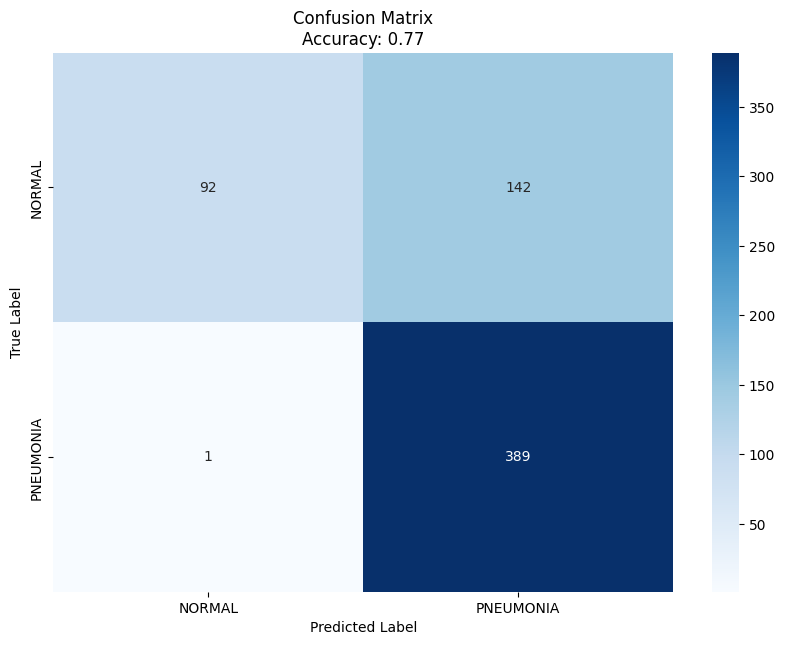

Accuracy: 0.77
                     Image Name Correct
0             IM-0001-0001.jpeg      No
1             IM-0003-0001.jpeg      No
2             IM-0005-0001.jpeg      No
3             IM-0006-0001.jpeg      No
4             IM-0007-0001.jpeg      No
..                          ...     ...
619  person96_bacteria_465.jpeg     Yes
620  person96_bacteria_466.jpeg     Yes
621  person97_bacteria_468.jpeg     Yes
622  person99_bacteria_473.jpeg     Yes
623  person99_bacteria_474.jpeg     Yes

[624 rows x 2 columns]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import os # Import the os module
# Make predictions on the test set
test_predictions = trainer.predict(prepared_test)
preds = np.argmax(test_predictions.predictions, axis=1)
labels = test_predictions.label_ids

image_filenames = []
for img in dataset_test['image']:
    if isinstance(img, str):  # Check if it's already a filename string
        image_filenames.append(img)
    elif hasattr(img, 'filename'):  # Check if it has a filename attribute (e.g., PIL Image)
        image_filenames.append(os.path.basename(img.filename))  # Extract filename
    else:
        image_filenames.append('Unknown') # Handle cases where filename is not available
# #image_filenames = dataset_test['image']
# if isinstance(dataset_test['image'][0], str):  # Check if the first element is already a string
#     image_filenames = dataset_test['image']
# else:
#     image_filenames = [img.filename for img in dataset_test['image']]  # Extract filenames


# Compute the confusion matrix
cm = confusion_matrix(labels, preds)
accuracy = accuracy_score(labels, preds)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset_test.features['label'].names, yticklabels=dataset_test.features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()

print(f'Accuracy: {accuracy:.2f}')

# Display image names and whether the prediction was correct
results = []
for img, label, pred in zip(image_filenames, labels, preds):
    #img_name = img.split('/')[-1]  # Extract the image name
    img_name = os.path.basename(img)  # Use os.path.basename to extract the file name
    correct = 'Yes' if label == pred else 'No'
    results.append((img_name, correct))

# Convert results to a DataFrame for better display
results_df = pd.DataFrame(results, columns=['Image Name', 'Correct'])
print(results_df)


In [17]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image

# Path to your saved model directory
model_name_or_path = './Tb_Dataset'  # Replace with your actual path

# Load the feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(model_name_or_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to predict on a single image
def predict_tb(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = preds.argmax(dim=1).item()

    return predicted_class, preds[0][predicted_class].item()

# Path to the image you want to test
image_path = '/kaggle/working/chest_xray/chest_xray/test/PNEUMONIA/person66_virus_125.jpeg'  # Replace with your image path

# Predict on the image
predicted_class, confidence = predict_tb(image_path)
label_map = {0: 'No Pneumonia', 1: 'Pneumonia'}  # Adjust according to your label mapping
prediction = label_map[predicted_class]

# Print the prediction
print(f"Prediction: {prediction} (Confidence: {confidence:.2f})")


/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Prediction: Pneumonia (Confidence: 1.00)


  0%|          | 0/1000 [00:00<?, ?it/s]

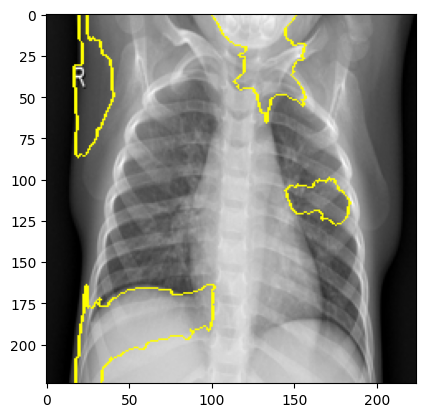

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load and preprocess the image
image_path = '/kaggle/working/chest_xray/chest_xray/test/NORMAL/IM-0069-0001.jpeg'
image = Image.open(image_path).convert('RGB')
image = np.array(image.resize((224, 224)))  # Resizing to model's input size

# Define the function to predict on images
def predict_fn(images):
    inputs = feature_extractor(images=list(images), return_tensors="pt").to(model.device)
    outputs = model(**inputs)
    return torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()

# Initialize LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

# Display explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]               


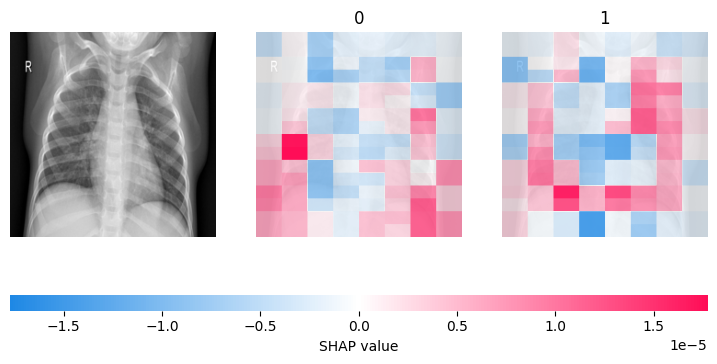

In [19]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

# Define model and feature extractor paths
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name_or_path)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load and preprocess the image
image_path = '/kaggle/working/chest_xray/chest_xray/test/NORMAL/IM-0069-0001.jpeg'
image = Image.open(image_path).convert('RGB')
image = np.array(image.resize((224, 224)))  # Resize to model's input size

def preprocess_images(images):
    inputs = feature_extractor(images=list(images), return_tensors="pt").to(model.device)
    return inputs['pixel_values']

def predict_fn(images):
    inputs = preprocess_images(images)
    outputs = model(pixel_values=inputs)
    return outputs.logits.detach().cpu().numpy()

# SHAP expects a batch of inputs
background = np.expand_dims(image, axis=0)
masker = shap.maskers.Image("inpaint_telea", background[0].shape)

explainer = shap.Explainer(predict_fn, masker, output_names=[str(i) for i in range(model.config.num_labels)])
shap_values = explainer(background)

# Visualize SHAP values
shap.image_plot(shap_values, background)

